## Demosaicing

In this assigment, we are going to 'demosaic' an image encoded with the Bayer Pattern. There are some cameras that use the Bayer Pattern in order to save an image. Using this encoding only 50% of green pixels, 25% of red pixels and 25% of blue pixels are kept. The Bayer encoding takes a RBG image and encodes it as in the bellow image. 
<img src="bayer_patterns.PNG" alt="Drawing" style="heigth: 300px;"/>




In this lab, we are going to 'demosaic' an encoded image in the **RGGB** pattern.   
<img src="bayer_rggb.PNG" alt="Drawing" style="width: 300px;"/>



We will implement a very simple algorithm which, for each pixel, fills in the two missing channels by averaging the values of their nearest neighbors (1, 2 or 4) in the corresponding channel.  
<img src="interpolation.PNG" alt="Drawing" style="width: 500px;"/>


To complete this task, we have to do:
- read the encoded image (crayons_mosaic.bmp)
- recreate the green, red and blue channel by copying the values into the corresponding positons of each channel
- interpolate the missing values in each channel

In [1]:
import numpy as np

H, W = 9, 9

r_mask = np.tile([[1, 0], [0, 0]], (H // 2 + 1, W // 2 + 1))
g_mask = np.tile([[0, 1], [1, 0]], (H // 2 + 1, W // 2 + 1))
b_mask = np.tile([[0, 0], [0, 1]], (H // 2 + 1, W // 2 + 1))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

encoded_image shape = (480, 600)


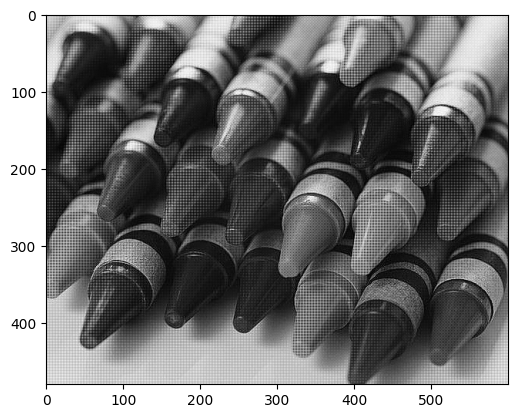

In [3]:
# read encoded image
encoded_image = plt.imread("crayons_mosaic.bmp").astype(np.float32)
plt.imshow(np.uint8(encoded_image), cmap='gray')
print('encoded_image shape = {}'.format(encoded_image.shape))

In [4]:
def split_r_b_g(encoded_image):
    """
    This function takes the encoded image and returns 
    R, G and B channels with the corresponding values taken from the encoded image.
    The image was encoded using the following pattern:
    R G
    G B
    The encoded image looks like:
    R G R G
    G B G B
    R G R G
    G B G B
    """
    height, width = encoded_image.shape
    r_channel = np.zeros((height, width), np.float32)
    g_channel = np.zeros((height, width), np.float32)
    b_channel = np.zeros((height, width), np.float32)

    for i in range(height):
        for j in range(width):
            if i % 2 == 0 and j % 2 == 0:
                r_channel[i][j] = encoded_image[i][j]
            elif i % 2 == 1 and j % 2 == 1:
                b_channel[i][j] = encoded_image[i][j]
            else:
                g_channel[i][j] = encoded_image[i][j]

    return r_channel, g_channel, b_channel

(480, 600, 3)


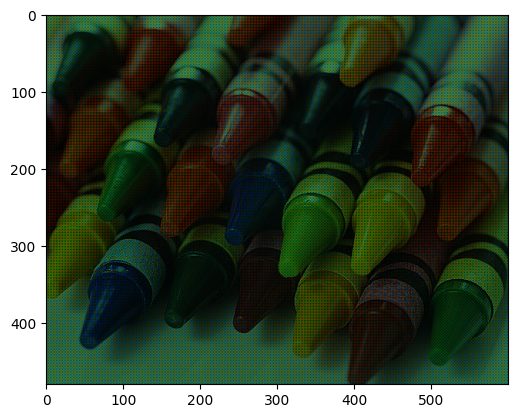

In [5]:
r_channel, g_channel, b_channel = split_r_b_g(encoded_image)
color_image = np.stack((r_channel, g_channel, b_channel), axis=2)
print(color_image.shape)
plt.imshow(np.uint8(color_image))

In [6]:
# print some values for the red channel:
print(r_channel[0:6, 0:6])

[[213.   0. 208.   0. 212.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [214.   0. 210.   0. 210.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [214.   0. 208.   0. 210.   0.]
 [  0.   0.   0.   0.   0.   0.]]


In [7]:
# print some values for the green channel:
print(g_channel[0:6, 0:6])

[[  0. 222.   0. 219.   0. 218.]
 [225.   0. 219.   0. 218.   0.]
 [  0. 221.   0. 217.   0. 216.]
 [223.   0. 217.   0. 215.   0.]
 [  0. 219.   0. 214.   0. 213.]
 [219.   0. 214.   0. 213.   0.]]


In [8]:
# print some values for the blue channel:
print(b_channel[0:6, 0:6])

[[  0.   0.   0.   0.   0.   0.]
 [  0. 210.   0. 203.   0. 200.]
 [  0.   0.   0.   0.   0.   0.]
 [  0. 207.   0. 201.   0. 197.]
 [  0.   0.   0.   0.   0.   0.]
 [  0. 201.   0. 195.   0. 191.]]


In [9]:
# define 4 types of interpolation based on the shape of neighboring pixels

def interpolate_4_points_plus(channel, i, j):
    # check boundaries
    if i - 1 < 0 or j - 1 < 0 or i + 1 >= channel.shape[0] or j + 1 >= channel.shape[1]:
        return    
    channel[i, j] = np.mean([channel[i - 1, j], channel[i, j + 1], channel[i + 1, j], channel[i, j - 1]])
    
def interpolate_4_points_diag(channel, i, j):
    # check boundaries
    if i - 1 < 0 or j - 1 < 0 or i + 1 >= channel.shape[0] or j + 1 >= channel.shape[1]:
        return    
    channel[i, j] = np.mean([channel[i - 1, j - 1], channel[i - 1, j + 1], channel[i + 1, j + 1], channel[i + 1, j - 1]])
    
def interpolate_2_points_horizontal(channel, i, j):
    if j - 1 < 0 or j + 1 >= channel.shape[1]:
        return
    channel[i, j] = np.mean([channel[i, j - 1], channel[i, j + 1]])
        
def interpolate_2_points_vertical(channel, i, j):
    if i - 1 < 0 or i + 1 >= channel.shape[0]:
        return
    channel[i, j] = np.mean([channel[i - 1, j], channel[i + 1, j]])


In [15]:
def interpolate_red_channel(red_channel: np.ndarray):
    """
    The red channel looks like:
    R 0 R 0 R 0 R 0
    0 0 0 0 0 0 0 0
    R 0 R 0 R 0 R 0
    0 0 0 0 0 0 0 0
    """
    interpolated_red_channel = red_channel.copy()
    height, width = interpolated_red_channel.shape

    for i in range(1, red_channel.shape[0] - 1, 2):
        for j in range(1, red_channel.shape[1] - 1, 2):
            if red_channel[i][j] != 0:
                continue
            interpolated_red_channel[i][j] = interpolate_4_points_diag(interpolated_red_channel, i, j)

    """
    Now red channel looks like:
    R 0 R 0 R 0 R 0
    0 R 0 R 0 R 0 0
    R 0 R 0 R 0 R 0
    0 0 0 0 0 0 0 0
    """
    for i in range(0, red_channel.shape[0] - 1, 2):
        for j in range(1, red_channel.shape[1] - 1, 2):
            if red_channel[i][j] != 0:
                continue
            interpolated_red_channel[i][j] = interpolate_2_points_horizontal(interpolated_red_channel, i, j)

    for i in range(1, red_channel.shape[0] - 1, 2):
        for j in range(0, red_channel.shape[1] - 1, 2):
            if red_channel[i][j] != 0:
                continue
            interpolated_red_channel[i][j] = interpolate_2_points_vertical(interpolated_red_channel, i, j)

    # 'interpolate' last line and last column
    interpolated_red_channel[height - 1] = interpolated_red_channel[height - 2]
    interpolated_red_channel[:, width - 1] = interpolated_red_channel[:, width - 2]
    return interpolated_red_channel

In [16]:
def interpolate_blue_channel(blue_channel):
    """
    The blue channel looks like:
    0 0 0 0 0 0 0 0
    0 B 0 B 0 B 0 B
    0 0 0 0 0 0 0 0
    0 B 0 B 0 B 0 B
    """
    interpolated_blue_channel = blue_channel.copy()
    height, width = interpolated_blue_channel.shape

    for i in range(2, blue_channel.shape[0], 2):
        for j in range(2, blue_channel.shape[1], 2):
            if blue_channel[i][j] != 0:
                continue
            interpolated_blue_channel[i][j] = interpolate_4_points_diag(interpolated_blue_channel, i, j)

    """
    Now the blue channel looks like:
    0 0 0 0 0 0 0 0
    0 B 0 B 0 B 0 B
    0 0 B 0 B 0 B 0
    0 B 0 B 0 B 0 B
    """
    for i in range(1, blue_channel.shape[0], 2):
        for j in range(2, blue_channel.shape[1], 2):
            if blue_channel[i][j] != 0:
                continue
            interpolated_blue_channel[i][j] = interpolate_2_points_horizontal(interpolated_blue_channel, i, j)

    for i in range(2, blue_channel.shape[0], 2):
        for j in range(1, blue_channel.shape[1], 2):
            if blue_channel[i][j] != 0:
                continue
            interpolated_blue_channel[i][j] = interpolate_2_points_vertical(interpolated_blue_channel, i, j)

    # 'interpolate' first line and first column
    interpolated_blue_channel[0] = interpolated_blue_channel[1]
    interpolated_blue_channel[:, 0] = interpolated_blue_channel[:, 1]
    return interpolated_blue_channel

In [17]:
def interpolate_green_channel(green_channel):
    """
    The green channel looks like:
    0 G 0 G 0 G 0 G
    G 0 G 0 G 0 G 0
    0 G 0 G 0 G 0 G
    G 0 G 0 G 0 G 0
    By now, we are going to ignore the margins.
    """
    interpolated_green_channel = green_channel.copy()
    height, width = interpolated_green_channel.shape

    # TODO: interpolate the points on 'plus' 
    for i in range(1, green_channel.shape[0], 2):
        for j in range(1, green_channel.shape[1], 2):
            if green_channel[i][j] != 0:
                continue
            interpolated_green_channel[i][j] = interpolate_4_points_plus(interpolated_green_channel, i, j)

    return interpolated_green_channel

In [18]:
b_int: np.ndarray = interpolate_blue_channel(b_channel)
r_int: np.ndarray = interpolate_red_channel(b_channel)
g_int: np.ndarray = interpolate_green_channel(b_channel)
color_image = np.stack((r_int, g_int, b_int),  axis=2).astype(np.uint8)

/tmp/ipykernel_30707/508150231.py:4: RuntimeWarning: invalid value encountered in cast
  color_image = np.stack((r_int, g_int, b_int),  axis=2).astype(np.uint8)


In [23]:
g_int.min()

0.0

In [20]:
cv.imwrite('color_image.png', color_image[:, :, [2, 1, 0]])
print(color_image.dtype)

uint8


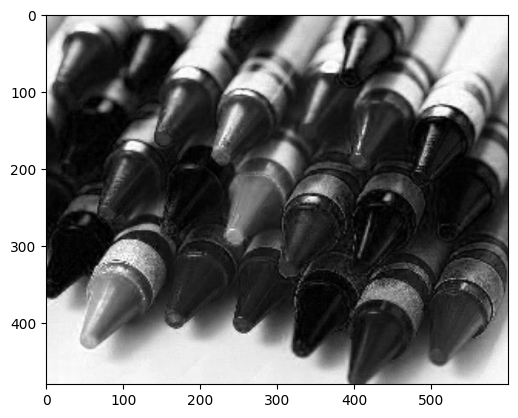

In [21]:
plt.imshow(np.uint8(color_image))